# Fraud Detection in Online Transactions

#### Importing Basic Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from datetime import date

%matplotlib inline
warnings.filterwarnings("ignore") # to ignore (not display) warnings
sns.set() # activate seaborn style

#### Exploratory Data Analysis

In [2]:
# importing data and displaying first 5 rows
df = pd.read_csv("Fraud_Data.csv")
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud
0,22058,2015-02-24 22:55:49,2015-04-18 2:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 1:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 7:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
# statistical description
df.describe()

,user_id,purchase_value,age,ip_address,is_fraud
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [4]:
# displays types of data held in each column
df.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
is_fraud            int64
dtype: object

There seems to be a problem with ip_address, since it is if type float64. Hence, we need to inspect this column. However, we shall first check for its correlation with the our problem: if it has a weak correlation, there will be no need for that column to be used in the first place.

In [5]:
# checking for missing values in every column
df.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
is_fraud          0
dtype: int64

Since all of the values are zeros, this indicates that there are no missing values in the dataset.

In [6]:
# checking for dupliacted data
df.duplicated().sum()

0

No duplicated data.

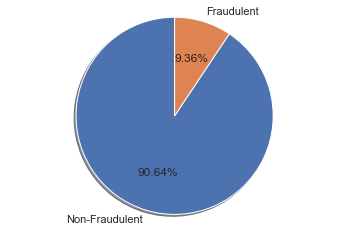

In [7]:
# checking for the total fraud cases with respext to the total observations
fraud_total = df["is_fraud"].value_counts() # counts the total number of observations where the transaction is frauduflent
fig, ax = plt.subplots()
labels_map = {0: "Non-Fraudulent", 1: "Fraudulent"}
ax.pie(fraud_total.values, labels=fraud_total.index.map(labels_map), autopct="%1.2f%%", shadow=True, startangle=90) # startangle 90 to rotate the chart by 90 degress counter-clockwise and autopct to display % of portions
ax.axis("equal")  # equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Fraudulent transactions are less than 10%.

In [8]:
# inspecting time gap between transactions to check if it impacts a transaction's type

# converting the data in the two time columns into pandas datetime data
df["signup_time"] = pd.to_datetime(df["signup_time"])
df["purchase_time"] = pd.to_datetime(df["purchase_time"])

# creating new column `time_difference` to calculate the time difference
df["time_difference"] = (df["signup_time"] - df["purchase_time"]).astype("timedelta64[m]") # astype casts the timedelta64[n] (nano seconds) into milliseconds in float format
df["time_difference"].head()

0   -75112.0
1     -300.0
2       -1.0
3    -8202.0
4   -72692.0
Name: time_difference, dtype: float64

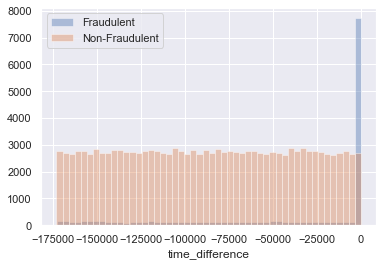

In [9]:
# plotting to see the impact of the time difference on the transaction's type
sns.distplot((df[df["is_fraud"]==1]["time_difference"]), label=pd.Series([1]).map(labels_map), bins=50, kde=False) # with kde=False, the plot will hide the kernel density estimation and only show the histogram
sns.distplot((df[df["is_fraud"]==0]["time_difference"]), label=pd.Series([0]).map(labels_map), bins=50, kde=False)
plt.legend()
plt.show()

It is obvious that transactions with a small time difference between the signup time and the transaction time are fraudulent. This is an important column.

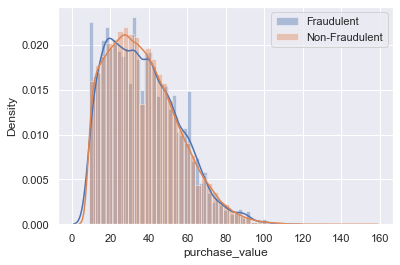

In [10]:
# checking pruchase_value
sns.distplot((df[df["is_fraud"]==1]["purchase_value"]), label=pd.Series([1]).map(labels_map), bins=50) # no need for kde=False because we wish to display the likelihood distribution
sns.distplot((df[df["is_fraud"]==0]["purchase_value"]), label=pd.Series([0]).map(labels_map), bins=50)
plt.legend()
plt.show()

Regarding the purchase value, there is not a significant difference between the two likelihoods: the two distributions are almost the same. This column does not hold valuable information.

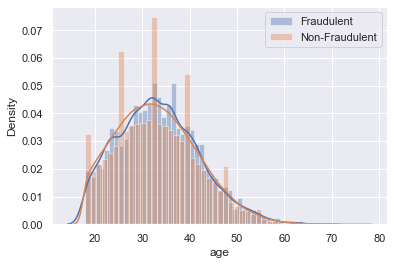

In [11]:
# checking age
sns.distplot((df[df["is_fraud"]==1]["age"]), label=pd.Series([1]).map(labels_map), bins=50) # no need for kde=False because we wish to display the likelihood distribution
sns.distplot((df[df["is_fraud"]==0]["age"]), label=pd.Series([0]).map(labels_map), bins=50)
plt.legend()
plt.show()

The same goes for age. However, it is worth mentioning that the distributions are very similar even when there are outliers in non-fraudulent transactions but not in fraudulent ones.

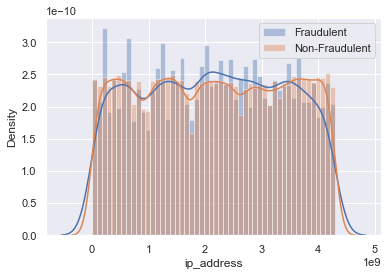

In [12]:
# checking ip_address
sns.distplot((df[df["is_fraud"]==1]["ip_address"]), label=pd.Series([1]).map(labels_map), bins=50)
sns.distplot((df[df["is_fraud"]==0]["ip_address"]), label=pd.Series([0]).map(labels_map), bins=50)
plt.legend()
plt.show()

Similar distributions for ip addresses as well. No further inspection is needed, i.e., the problem mentioned earlier (float type) does not need to be addressed since this column will not be useful when classifying.

In [13]:
# checking for unique values in device_id
df["device_id"].nunique()

137956

In device_id, there are 137,956 unique values: it is not feasible nor it is efficient to use one hot encoding to represent such data. Hence, this column shall be dropped.

In [14]:
# checking for unique values in device_id
df["user_id"].nunique()

151112

The total number of unique observations is equal to the total number of observations. Hence, every purchase has a unique user. Therefore, this column is unuseful.

In [15]:
# checking for unique values in source
df["source"].nunique()

3

There are only 3 unique sources. It is worth one hot encoding to see if source is significant to the classifcation in hand.

In [16]:
# one hot encoding of source
source_encoded = pd.get_dummies(df["source"], prefix="encoded", drop_first=True) # drop first is to avoid dependancy among variables
df = pd.concat([df, source_encoded], axis=1)
df.loc[:, ["encoded_Direct", "encoded_SEO"]].head(15) # display 1st 15 rows of the encoded columns

,encoded_Direct,encoded_SEO
0,0,1
1,0,0
2,0,1
3,0,1
4,0,0
5,0,0
6,0,0
7,0,0
8,0,1
9,0,0


- 0 in encoded_Direct and 1 in encoded_SEO: source is SEO
- 1 in encoded_Direct and 0 in encoded_SEO: source is Direct
- 0 in encoded_Direct and 0 in encoded_SEO: source is Ads

In [17]:
# checking for unique values in browser
df["browser"].nunique()

5

We shall one hot encode browser.

In [18]:
# one hot encoding of browser
browser_encoded = pd.get_dummies(df["browser"], prefix="encoded", drop_first=True) # drop first is to avoid dependancy among variables
df = pd.concat([df, browser_encoded], axis=1)
df.loc[:, browser_encoded.columns].head()

,encoded_FireFox,encoded_IE,encoded_Opera,encoded_Safari
0,0,0,0,0
1,0,0,0,0
2,0,0,1,0
3,0,0,0,1
4,0,0,0,1


Sex will be encoded as well: it is either male or female (M or F, respectively), i.e., it can be represented as 1s or 0s.

In [19]:
# mapping male and female in sex to 1 and 0, respectively.
sex_map = {"M": 1, "F": 0}
df["sex"] = df["sex"].map(sex_map)
df["sex"].head()

0    1
1    0
2    1
3    1
4    1
Name: sex, dtype: int64

Now, unuseful columns shall be dropped.

In [20]:
# displaying all columns
df.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address',
       'is_fraud', 'time_difference', 'encoded_Direct', 'encoded_SEO',
       'encoded_FireFox', 'encoded_IE', 'encoded_Opera', 'encoded_Safari'],
      dtype='object')

Verifying our analysis using correlation matrix of variables.

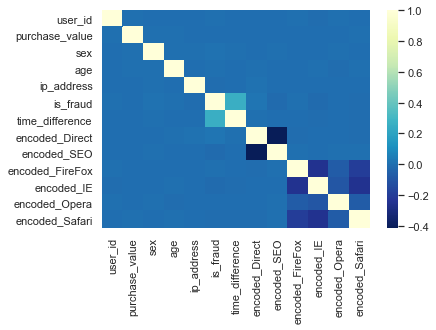

In [21]:
sns.heatmap(df.corr(), cmap="YlGnBu_r")
plt.show()

From the heatmap, we are able to trust our analysis results.

Columns with reasons to drop:
- user_id, purchase_value, device_id, age, ip_address: unuseful columns.
- signup_time, purchase_time: represented by the new column time_difference that represents the difference between them.
- source, browser: one hot encoded.

In [22]:
# creating a list of columns to be dropped
columns_drop = ["user_id", "signup_time", "purchase_time", "purchase_value", "device_id", "source", "browser", "age", "ip_address"]

# dropping columns and copy the remaining into a new dataframe (to have a checkpoint for df in case of any mistakes later on)
df_clean = df.drop(columns_drop, axis=1)
df_clean.head()

,sex,is_fraud,time_difference,encoded_Direct,encoded_SEO,encoded_FireFox,encoded_IE,encoded_Opera,encoded_Safari
0,1,0,-75112.0,0,1,0,0,0,0
1,0,0,-300.0,0,0,0,0,0,0
2,1,1,-1.0,0,1,0,0,1,0
3,1,0,-8202.0,0,1,0,0,0,1
4,1,0,-72692.0,0,0,0,0,0,1


#### Data Preparation

In [23]:
# creating dependant variables (X) set and independant variable (y) set
X = df_clean.drop(["is_fraud"], axis=1)
y = df_clean["is_fraud"]

In [24]:
X.head()

,sex,time_difference,encoded_Direct,encoded_SEO,encoded_FireFox,encoded_IE,encoded_Opera,encoded_Safari
0,1,-75112.0,0,1,0,0,0,0
1,0,-300.0,0,0,0,0,0,0
2,1,-1.0,0,1,0,0,1,0
3,1,-8202.0,0,1,0,0,0,1
4,1,-72692.0,0,0,0,0,0,1


In [25]:
y.head()

0    0
1    0
2    1
3    0
4    0
Name: is_fraud, dtype: int64

In [26]:
# scaling time_difference
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
scaled_features = sc_X.fit_transform(np.array(X["time_difference"].values).reshape(-1,1))
X_scaled = X.drop(["time_difference"], axis=1)
X_scaled["time_difference"] = scaled_features

In [27]:
X_scaled.head()

,sex,encoded_Direct,encoded_SEO,encoded_FireFox,encoded_IE,encoded_Opera,encoded_Safari,time_difference
0,1,0,1,0,0,0,0,0.136054
1,0,0,0,0,0,0,0,1.571870
2,1,0,1,0,0,1,0,1.577609
3,1,0,1,0,0,0,1,1.420213
4,1,0,0,0,0,0,1,0.182500


In [28]:
#splitting data into training data and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.1, random_state=123)
for name, dataset in list(zip(("X_train", "X_test", "y_train", "y_test"),(X_train, X_test, y_train, y_test))):
    print("Shape of {name}: {dataset_shape}".format(name=name, dataset_shape=dataset.shape))

Shape of X_train: (136000, 8)
Shape of X_test: (15112, 8)
Shape of y_train: (136000,)
Shape of y_test: (15112,)


#### Model Selection and Evaluation

In [29]:
# importing evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

Linear Regression

In [30]:
# building classifier
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [31]:
# getting accuracy
test_acc_lr = accuracy_score(y_test, y_pred_lr)
test_acc_lr

0.9011381683430386

In [32]:
# getting  precision_score
precision_score_lr = precision_score(y_test, y_pred_lr)
precision_score_lr

0.0

In [33]:
# getting  recall
recall_score_lr = recall_score(y_test, y_pred_lr)
recall_score_lr

0.0

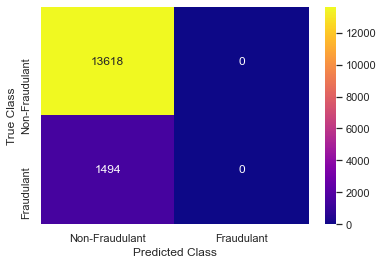

In [34]:
# plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
ax = sns.heatmap(cm, cmap="plasma", annot=True, fmt="d")
ax.set_ylabel("True Class")
ax.set_xlabel("Predicted Class")
labels=["Non-Fraudulant", "Fraudulant"]
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

Decision Tree

In [35]:
# building classifier
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [36]:
# getting accuracy
test_acc_dt = accuracy_score(y_test, y_pred_dt)
test_acc_dt

0.9111964002117523

In [37]:
# getting  precision_score
precision_score_dt = precision_score(y_test, y_pred_dt)
precision_score_dt

0.5500658761528326

In [38]:
# getting  recall
recall_score_dt = recall_score(y_test, y_pred_dt)
recall_score_dt

0.5589022757697456

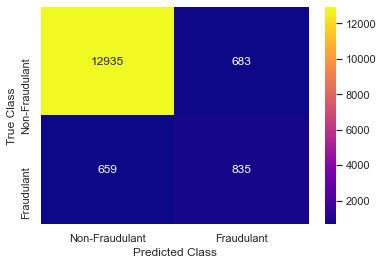

In [39]:
# plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)
ax = sns.heatmap(cm, cmap="plasma", annot=True, fmt="d")
ax.set_ylabel("True Class")
ax.set_xlabel("Predicted Class")
labels=["Non-Fraudulant", "Fraudulant"]
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

Random Forest

In [40]:
# building classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [41]:
# getting accuracy
test_acc_rf = accuracy_score(y_test, y_pred_rf)
test_acc_rf

0.9151005823186872

In [42]:
# getting  precision_score
precision_score_rf = precision_score(y_test, y_pred_rf)
precision_score_rf

0.5725085910652921

In [43]:
# getting  recall
recall_score_rf = recall_score(y_test, y_pred_rf)
recall_score_rf

0.5575635876840697

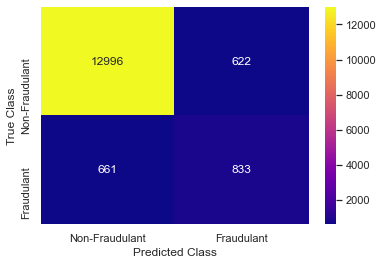

In [44]:
# plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
ax = sns.heatmap(cm, cmap="plasma", annot=True, fmt="d")
ax.set_ylabel("True Class")
ax.set_xlabel("Predicted Class")
labels=["Non-Fraudulant", "Fraudulant"]
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

Artificial Neural Network (ANN)

In [45]:
# building ANN
from keras.models import Sequential
from keras.layers import Dense

model=Sequential()
model.add(Dense(64,input_dim=8,activation="relu"))
model.add(Dense(128,input_dim=64,activation="relu"))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
results = model.fit(X_train, y_train, epochs=10)

Using TensorFlow backend.


Epoch 1/10
136000/136000 [==============================] - 5s 40us/step - loss: 0.2303 - accuracy: 0.9313
Epoch 2/10
136000/136000 [==============================] - 5s 39us/step - loss: 0.2073 - accuracy: 0.9431
Epoch 3/10
136000/136000 [==============================] - 5s 39us/step - loss: 0.2037 - accuracy: 0.9450
Epoch 4/10
136000/136000 [==============================] - 5s 40us/step - loss: 0.2010 - accuracy: 0.9462
Epoch 5/10
136000/136000 [==============================] - 5s 40us/step - loss: 0.2007 - accuracy: 0.9466
Epoch 6/10
136000/136000 [==============================] - 5s 40us/step - loss: 0.2002 - accuracy: 0.9470
Epoch 7/10
136000/136000 [==============================] - 5s 40us/step - loss: 0.1975 - accuracy: 0.9480
Epoch 8/10
136000/136000 [==============================] - 6s 41us/step - loss: 0.1977 - accuracy: 0.9481
Epoch 9/10
136000/136000 [==============================] - 5s 39us/step - loss: 0.1973 - accuracy: 0.9482
Epoch 10/10
136000/136000 [==========

In [46]:
# getting accuracy accross the 10 epochs (training)
avg_train_acc_ann = np.round(sum(results.history["accuracy"]) / len(results.history["accuracy"])*100, 2)
avg_train_acc_ann

94.52

In [47]:
# prediciting with ANN
y_pred_ann = model.predict(X_test)
y_pred_ann = np.squeeze((y_pred_ann > 0.5) * 1) # every probability > 0.5 is of class 1 (fraudulent) and <=0.5 is of class 0 (non-fraudulent)

# printing the predictions vector's shape
y_pred_ann.shape # should be the same as y_test

(15112,)

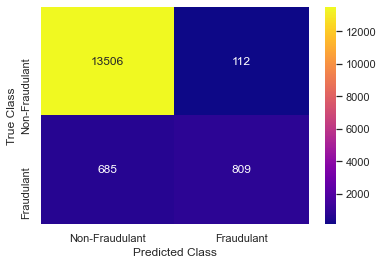

In [48]:
# plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred_ann)
ax = sns.heatmap(cm, cmap="plasma", annot=True, fmt="d")
ax.set_ylabel("True Class")
ax.set_xlabel("Predicted Class")
labels=["Non-Fraudulant", "Fraudulant"]
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [49]:
# getting testing accuracy
test_acc_ann = np.round((cm[0][0] + cm[1][1]) / np.sum(cm), 2)
test_acc_ann

0.95

In [50]:
# getting precision
precision_score_ann = precision_score(y_test, y_pred_ann)
precision_score_ann

0.8783930510314875

In [51]:
# getting recall score
recall_score_ann = recall_score(y_test, y_pred_ann)
recall_score_ann

0.5414993306559571

#### Results and Discussion

Our goal here is to reduce the False Positives (predicting the Fraudulant as Non-Fraudulant) as much as possible. Therefore, the accuracy and the precision scores are the two most important metrics in our case: it is acceptable if we predict non-fraudulent cases as fraudulent, but not the other way around.

Testing Accuracy quantifies the number of correct class predictions made out of all the actual classes: A = (TP + TN) / (TP + TN + FP + FN).

Precision quantifies the number of positive class predictions that actually belong to the positive class: P = TP / (TP + FP).

Recall quantifies the number of positive class predictions made out of all positive examples in the dataset: R = TP / (TP + FN).

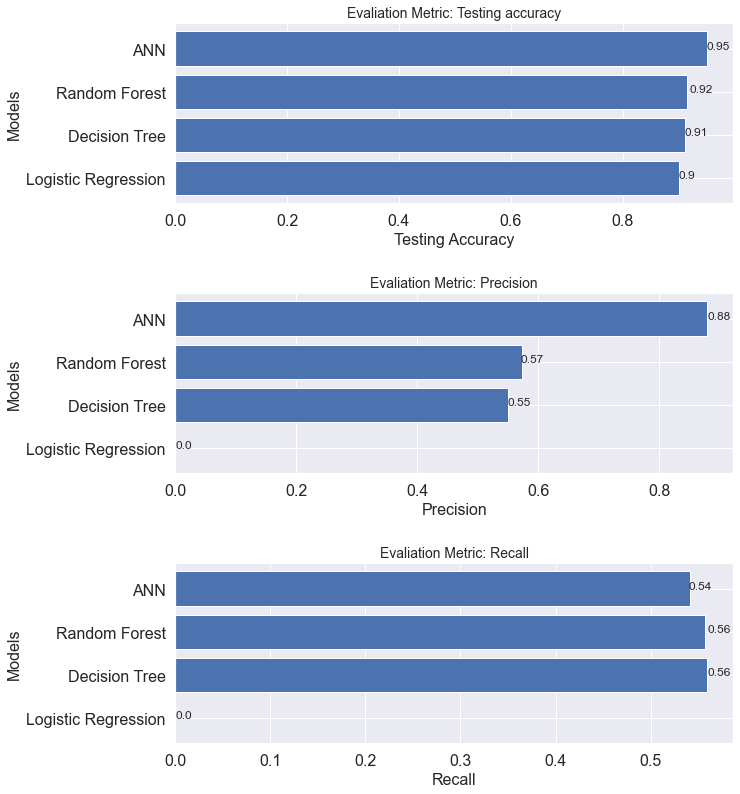

In [52]:
# plotting evaluation metrics
models_names = ["Logistic Regression", "Decision Tree", "Random Forest", "ANN"]
scores_names = ["Testing Accuracy", "Precision", "Recall"]
test_accs = [test_acc_lr, test_acc_dt, test_acc_rf, test_acc_ann]
precision_scores = [precision_score_lr, precision_score_dt, precision_score_rf, precision_score_ann]
recall_scores = [recall_score_lr, recall_score_dt, recall_score_rf, recall_score_ann]
scores_list = [test_accs, precision_scores, recall_scores] 
fig,axes=plt.subplots(3,1,figsize=(10,10))
i=0
for score_name,score_list in list(zip(scores_names, scores_list)):
    i=i+1
    plt.subplot(3,1,i)
    plt.subplots_adjust(top=1.0, bottom=0.0, hspace=0.5) # space between each subplot
    plt.barh(models_names,score_list) # model_names = y-axis, score_list = x-axis
    plt.title("Evaliation Metric: "+score_name.split("_")[0].capitalize(),fontsize=14)
    plt.xlabel(score_name,fontsize=16)
    plt.ylabel("Models",fontsize=16)
    for index, value in enumerate(score_list):
        plt.text(round(value,2), index, str(round(value,2)))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
plt.show()

We can observe the following points:
- Logistic Regression has a high Testing Accuracy but a null Recall and Precision. Hence, it fails to identify fraudulent cases and predicts that all cases are non-fraudulent.
- Decision Tree and Random Forest have high Testing Accuracies and higher Recall than ANN (lower FP), but much lower Precision (higher FN). This is a problem because FN represents fraudulent cases predicted as non-fraudulent.
- ANN has the highest Testing Accuracy, highest precision (0.88) which is very importan because it means that it is efficiently detecting fraudulent cases (our main goal). However, it has a slightly lower Recall than Random Forest and Decision Tree, but it is acceptable since we can tolerate predicting a non-fraudulent case as fraudulent.

#### Conclusion

From the results discussed above, it is obvious that ANN is the best model in our case scenario, with the dataset available in hand.